In [7]:
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from reservoirpy import datasets
from reservoirpy.nodes import Reservoir, Ridge
import networkx as nx
import reservoirpy as rpy
rpy.verbosity(0)

0

In [16]:
n_timesteps = 2000
X = datasets.mackey_glass(n_timesteps=n_timesteps, sample_len=2000)
Y = np.roll(X, -1)

train_end = int(len(X) * 0.7)
test_start = train_end + 1
X_train, Y_train = X[:train_end], Y[:train_end]
X_test, Y_test = X[test_start:], Y[test_start:]
#X_train = X_train.reshape(-1, 1)  # Reshape to (n_samples, 1) if X_train was a flat array

# Ensure X and Y are correctly shaped for ReservoirPy
X_train = X_train.reshape(-1, 1)
Y_train = Y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)



# Example call (Ensure correct values for population_size and genome_length)
population_size = 50
genome_length = 100
n_generations = 50
num_nodes=100
mutation_rate = 0.1

In [13]:
def initialize_population(size, genome_length):
    return [initialize_genome(genome_length) for _ in range(size)]

def initialize_genome(genome_length):
    genome = []
    for _ in range(genome_length):
        gene = (np.random.randint(0, 10), np.random.randint(0, 10), np.random.uniform(-1, 1))
        genome.append(gene)
    return genome

def evaluate_fitness(population, X_train, Y_train, X_test, Y_test):
    fitness_scores, rmse_scores, mae_scores, mse_scores = [], [], [], []
    for genome in population:
        rmse, mae, mse = train_and_evaluate(genome, X_train, Y_train, X_test, Y_test)
        fitness_scores.append(rmse)  # Example: Using RMSE as the fitness score
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        mse_scores.append(mse)
    return fitness_scores, rmse_scores, mae_scores, mse_scores

def genome_to_weight_matrix(genome, num_nodes):
    W = np.zeros((num_nodes, num_nodes))
    for i, j, w in genome:
        W[i, j] = w
    return W


def train_and_evaluate(genome, X_train, Y_train, X_test, Y_test, num_nodes):
    W = genome_to_weight_matrix(genome, num_nodes)
    #esn = Reservoir(num_nodes, lr=0.3, W=W) >> Ridge(0.01)
    esn = Reservoir(num_nodes, lr=0.3, W=W) >> Ridge(ridge=0.01)


    esn.fit(X_train, Y_train)
    Y_pred = esn.run(X_test)

    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    return rmse, mae, mse


def select_fittest(population, fitness_scores, selection_size):
    selected_indices = np.argsort(fitness_scores)[:selection_size]
    return [population[i] for i in selected_indices], [fitness_scores[i] for i in selected_indices]


def reproduce(selected_genomes, population_size):
    new_population = []
    while len(new_population) < population_size:
        parent = np.random.choice(selected_genomes)
        child = mutate_genome_with_hox(parent)
        new_population.append(child)
    return new_population


    
def tournament_selection(population, fitness_scores, tournament_size=5):
    selected = []
    for _ in range(len(population)):
        participants = random.sample(list(zip(population, fitness_scores)), tournament_size)
        winner = min(participants, key=lambda p: p[1])
        selected.append(winner[0])
    return selected

In [17]:
def plot_performance(rmse_scores, mae_scores, mse_scores): 
    plt.figure(figsize=(12, 6))
    plt.plot(rmse_scores, marker='o', linestyle='-', color='b', label='RMSE')
    plt.title('Performance Scores Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('RMSE Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(mse_scores, marker='^', linestyle='-', color='g', label='MSE')
    plt.title('Performance Scores Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('MSE Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(mae_scores, marker='x', linestyle='-', color='r', label='MAE')
    plt.title('Performance Scores Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('MAE Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
def mutate_genome_with_hox_old(genome, num_nodes):
    
    genome = copy.deepcopy(genome)


    mutation_type = np.random.choice([
        'add_node', 'remove_node', 'add_connection', 
        'remove_connection', 'copy_subgenome', 
        'remove_subgenome', 'shuffle_subgenome'
    ])

    if mutation_type == 'add_node':
        genome = add_node(genome, num_nodes)
    elif mutation_type == 'remove_node':
        genome = remove_node(genome)
    elif mutation_type == 'add_connection':
        genome = add_connection(genome, num_nodes)
    elif mutation_type == 'remove_connection':
        genome = remove_connection(genome)
    elif mutation_type == 'copy_subgenome':
        genome = copy_subgenome(genome)
    elif mutation_type == 'remove_subgenome':
        genome = remove_subgenome(genome)
    elif mutation_type == 'shuffle_subgenome':
        genome = shuffle_subgenome(genome)
    
    genome = compress_genome(genome, num_nodes)
    return genome

def mutate_genome_with_hox(genome, num_nodes, mutation_rate):
    if random.random() < mutation_rate:
        mutation_type = np.random.choice([
            'add_node', 'remove_node', 'add_connection', 
            'remove_connection', 'copy_subgenome', 
            'remove_subgenome', 'shuffle_subgenome'
        ], p=[0.2, 0.2, 0.2, 0.2, 0.05, 0.05, 0.1])  # Example mutation probabilities

        if mutation_type == 'add_node':
            genome = add_node(genome, num_nodes)
        elif mutation_type == 'remove_node':
            genome = remove_node(genome)
        elif mutation_type == 'add_connection':
            genome = add_connection(genome, num_nodes)
        elif mutation_type == 'remove_connection':
            genome = remove_connection(genome)
        elif mutation_type == 'copy_subgenome':
            genome = copy.deepcopy(genome)  # Apply deepcopy only when needed
            genome = copy_subgenome(genome)
        elif mutation_type == 'remove_subgenome':
            genome = remove_subgenome(genome)
        elif mutation_type == 'shuffle_subgenome':
            genome = shuffle_subgenome(genome)
        
        genome = compress_genome(genome, num_nodes)
    return genome


def add_node(genome, num_nodes):
    # Example: Adding a new connection instead of a standalone node due to ESN structure
    new_gene = (np.random.randint(0, num_nodes), np.random.randint(0, num_nodes), np.random.uniform(-1, 1))
    genome.append(new_gene)
    return genome

def remove_node(genome):
    if genome:
        genome.pop(np.random.randint(len(genome)))
    return genome

def add_connection(genome, num_nodes):
    return add_node(genome, num_nodes)  # Equivalent to adding a node/connection

def remove_connection(genome):
    return remove_node(genome)  # Equivalent to removing a node/connection

def copy_subgenome(genome):
    if genome:
        index = np.random.randint(len(genome))
        #genome.append(genome[index].copy())
        #genome_copy = tuple(genome[index])
        genome_copy = tuple(copy.deepcopy(genome[index]))
        genome.append(genome_copy)
    return genome

def remove_subgenome(genome):
    if len(genome) > 1:
        del genome[np.random.randint(len(genome))]
    return genome

def shuffle_subgenome(genome):
    np.random.shuffle(genome)
    return genome

def compress_genome(genome, num_nodes):
    # Ensure all gene indices are within bounds after mutations
    compressed_genome = [(i % num_nodes, j % num_nodes, w) for i, j, w in genome]
    return compressed_genome


In [18]:
def run_evolution(X_train, Y_train, X_test, Y_test, generations, population_size, genome_length, num_nodes):
    # Initialize the population with random genomes
    population = [initialize_genome(genome_length) for _ in range(population_size)]
    best_rmse, best_mae, best_mse = [], [], []
    
    # Initialize mutation rate
    mutation_rate = 0.1

    for generation in range(generations):
        fitness_scores, rmse_scores, mae_scores, mse_scores = [], [], [], []

        # Evaluate each genome in the population
        for genome in population:
            rmse, mae, mse = train_and_evaluate(genome, X_train, Y_train, X_test, Y_test, num_nodes)
            fitness_scores.append(rmse)  # Using RMSE as fitness score for selection
            rmse_scores.append(rmse)
            mae_scores.append(mae)
            mse_scores.append(mse)
        
        # Select the fittest half of the population
        ##selected_indices = np.argsort(fitness_scores)[:population_size // 2]
        ##selected_genomes = [population[i] for i in selected_indices]
        
        # Use tournament selection for choosing the parents for reproduction
        selected_genomes = tournament_selection(population, fitness_scores, tournament_size=5)
        
        # Dynamically adjust the mutation rate if needed
        # Example: reduce mutation rate over generations
        mutation_rate *= 0.99  # Decaying mutation rate

        # Reproduce to create a new population, applying HOX mutations
        new_population = []
        while len(new_population) < population_size:
            ##parent_genome = selected_genomes[np.random.randint(len(selected_genomes))]
            ##mutated_genome = mutate_genome_with_hox(parent_genome, num_nodes)
            parent_genome = random.choice(selected_genomes)
            mutated_genome = mutate_genome_with_hox(parent_genome, num_nodes, mutation_rate)
            new_population.append(mutated_genome)
        population = new_population
        

        # Track and print the best performance metrics of the generation
        best_rmse.append(np.min(rmse_scores))
        best_mae.append(np.min(mae_scores))
        best_mse.append(np.min(mse_scores))
        print(f"Generation {generation}: Best RMSE: {best_rmse[-1]}, Best MAE: {best_mae[-1]}, Best MSE: {best_mse[-1]}")

    # Plot the performance evolution
    plot_performance(best_rmse, best_mae, best_mse)

Generation 0: Best RMSE: 0.03221266538266345, Best MAE: 0.013628548377800084, Best MSE: 0.0010376558110554443
Generation 1: Best RMSE: 0.031560787995773845, Best MAE: 0.012322353402902865, Best MSE: 0.0009960833389141823
Generation 2: Best RMSE: 0.03170640163977149, Best MAE: 0.011670829684239199, Best MSE: 0.0010052959049425042
Generation 3: Best RMSE: 0.030790122889873404, Best MAE: 0.010936810071394534, Best MSE: 0.000948031667573506
Generation 4: Best RMSE: 0.03356817945667708, Best MAE: 0.01603702456037893, Best MSE: 0.0011268226720356773
Generation 5: Best RMSE: 0.032380469493759216, Best MAE: 0.01484908561091123, Best MSE: 0.001048494804636271
Generation 6: Best RMSE: 0.03158710857277169, Best MAE: 0.012857556014735034, Best MSE: 0.0009977454279880666
Generation 7: Best RMSE: 0.03181462308267274, Best MAE: 0.012704711050173224, Best MSE: 0.0010121702418925329
Generation 8: Best RMSE: 0.031213548678637414, Best MAE: 0.011376773062825335, Best MSE: 0.0009742856211136674
Generation

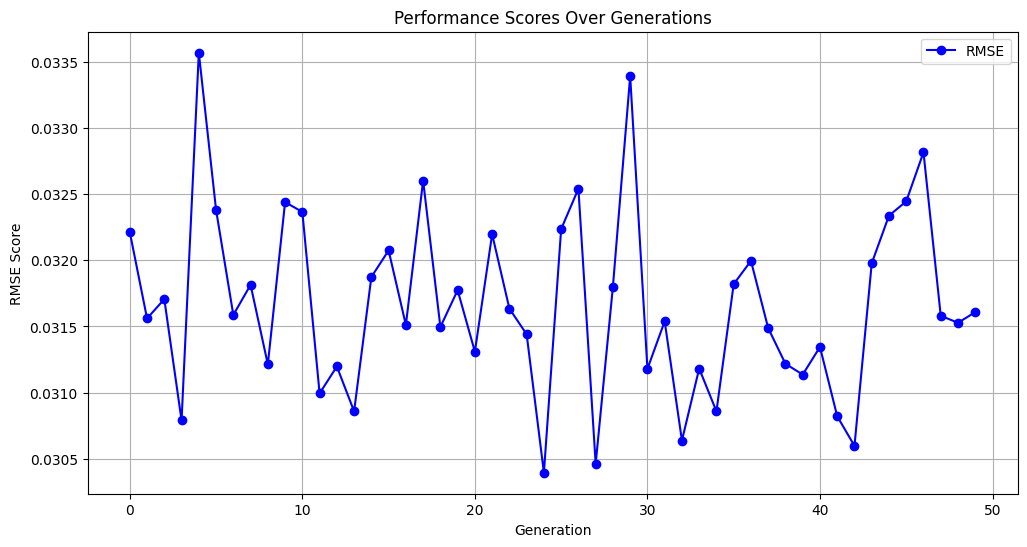

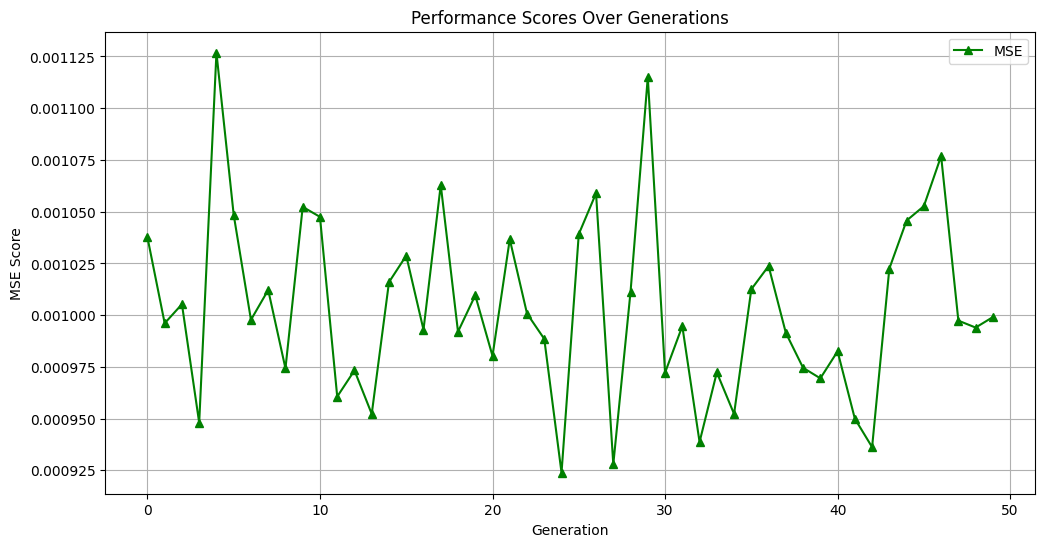

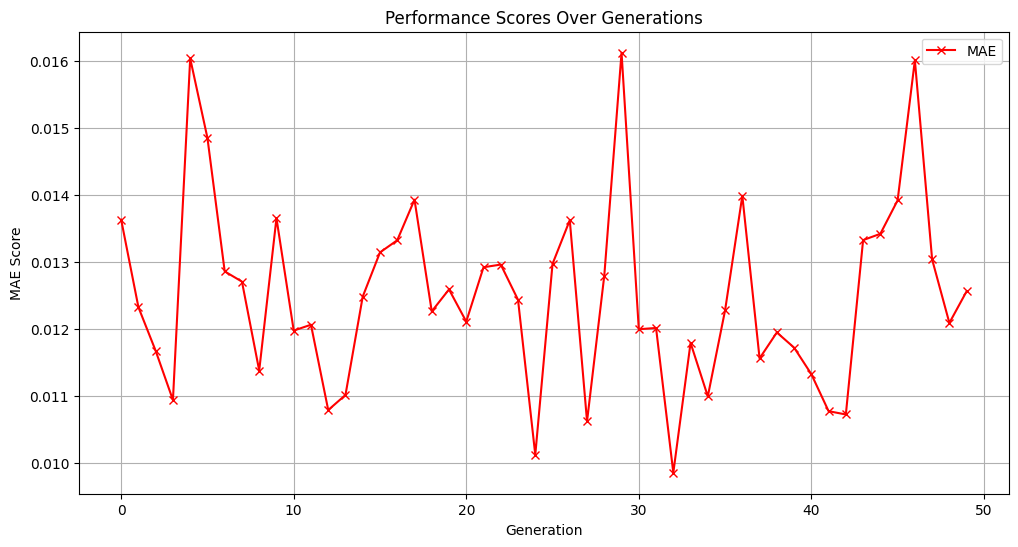

In [19]:
if __name__ == "__main__":
    # Load or generate dataset
    #X_train, Y_train, X_test, Y_test = load_dataset()  # Define this function based on your data preparation
    run_evolution(X_train, Y_train, X_test, Y_test, n_generations, population_size, genome_length, num_nodes)